Installation of necessary packages (and creation of a conda env):
```
./install_main.sh 
```

Process results obtained via running command:
```
bash -i run_qa_main.sh
```

In [1]:
SEED_QTY=3
TRAIN_QTY=40000
SUBSET=('small' if TRAIN_QTY == 4000 else 'large')
OUTPUT_PREF='results_qa_bf16_g5'

In [2]:
sync_step_arr = [1, 2, 4, 8, 16, 24, 32, 64]

In [3]:
EXPER_SERIES={
    '1gpu' : ['1gpu', [(f'output_res_{TRAIN_QTY}', '')]],
    '4gpus accum': ['4gpus', [(f'output_res_{TRAIN_QTY}_accum_steps_{k}', k) for k in sync_step_arr]],
    '8gpus accum': ['8gpus', [(f'output_res_{TRAIN_QTY}_accum_steps_{k}', k) for k in sync_step_arr]],
    '4gpus Local SGD': ['4gpus', [(f'output_res_{TRAIN_QTY}_nosync_steps_{k}', k) for k in sync_step_arr]],
    '8gpus Local SGD': ['8gpus', [(f'output_res_{TRAIN_QTY}_nosync_steps_{k}', k) for k in sync_step_arr]],    
}

In [4]:
EXPER_SERIES

{'1gpu': ['1gpu', [('output_res_40000', '')]],
 '4gpus accum': ['4gpus',
  [('output_res_40000_accum_steps_1', 1),
   ('output_res_40000_accum_steps_2', 2),
   ('output_res_40000_accum_steps_4', 4),
   ('output_res_40000_accum_steps_8', 8),
   ('output_res_40000_accum_steps_16', 16),
   ('output_res_40000_accum_steps_24', 24),
   ('output_res_40000_accum_steps_32', 32),
   ('output_res_40000_accum_steps_64', 64)]],
 '8gpus accum': ['8gpus',
  [('output_res_40000_accum_steps_1', 1),
   ('output_res_40000_accum_steps_2', 2),
   ('output_res_40000_accum_steps_4', 4),
   ('output_res_40000_accum_steps_8', 8),
   ('output_res_40000_accum_steps_16', 16),
   ('output_res_40000_accum_steps_24', 24),
   ('output_res_40000_accum_steps_32', 32),
   ('output_res_40000_accum_steps_64', 64)]],
 '4gpus Local SGD': ['4gpus',
  [('output_res_40000_nosync_steps_1', 1),
   ('output_res_40000_nosync_steps_2', 2),
   ('output_res_40000_nosync_steps_4', 4),
   ('output_res_40000_nosync_steps_8', 8),
   ('ou

In [5]:
import json
import numpy as np

col_name = []
col_time = []

col_exact_avg = []
col_exact_max = []
col_f1_avg = []
col_f1_max = []
col_steps = []

col_speedup = []

def agg_val(json_arr, key):
    res = []
    for e in json_arr:
        res.append(e[key])
    return np.mean(res), np.max(res)

baseline_time = None

for ser_k, ser_def in EXPER_SERIES.items():
    top_sub_dir, add_sub_dirs = ser_def
    for add_sub, steps in add_sub_dirs:
        data = []
        for seed in range(SEED_QTY):
            data.append(json.load(open(f'{OUTPUT_PREF}/{top_sub_dir}/{add_sub}/{seed}/all_results.json')))
        #print(ser_k, steps)
        col_name.append(f'{ser_k}')
        col_steps.append(str(steps))
        col_time.append(round(agg_val(data, 'eval_train_time')[0], 0))
        
        col_speedup.append(round(col_time[0] / col_time[-1], 1))
        
        avg, mx = agg_val(data, 'eval_exact_match')
        col_exact_avg.append(round(avg, 3))
        col_exact_max.append(round(mx, 3))
        
        avg, mx = agg_val(data, 'eval_f1')
        col_f1_avg.append(round(avg, 3))
        col_f1_max.append(round(mx, 3))        

In [6]:

res_dict_str = {'method': col_name, 'steps': col_steps, 
                'time': col_time, 'speedup': col_speedup,
                'exact match (avg)': col_exact_avg, 'exact match (max)': col_exact_max,
                'F1 (avg)': col_f1_avg, 'f1 (max)': col_f1_max}

In [7]:
import pandas as pd
df=pd.DataFrame.from_dict(res_dict_str)
df.to_excel(f'QA_{SUBSET}.xls')

/var/folders/zx/6p0tyww13rn7xbr8p28vpdbm0000gn/T/ipykernel_54447/105555628.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(f'QA_{SUBSET}.xls')


In [8]:
df

,method,steps,time,speedup,exact match (avg),exact match (max),F1 (avg),f1 (max)
0,1gpu,,3892.0,1.0,81.224,81.504,89.031,89.295
1,4gpus accum,1,4499.0,0.9,80.303,81.060,88.307,88.691
2,4gpus accum,2,2616.0,1.5,80.883,81.050,88.624,88.682
3,4gpus accum,4,1694.0,2.3,80.438,80.577,88.348,88.373
4,4gpus accum,8,1206.0,3.2,78.732,80.028,87.019,87.985
5,4gpus accum,16,960.0,4.1,78.376,78.912,86.741,87.263
6,4gpus accum,24,876.0,4.4,76.459,76.698,85.242,85.446
7,4gpus accum,32,834.0,4.7,74.481,76.727,83.812,85.525
8,4gpus accum,64,766.0,5.1,69.164,69.915,79.377,79.864
9,8gpus accum,1,2365.0,1.6,80.719,80.842,88.584,88.804


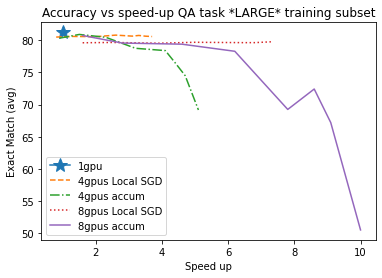

In [9]:
import matplotlib.pyplot as plt

# Define a list of line styles to use for each group
linestyles = ['-', '--', '-.', ':']

# Group the DataFrame by the 'method' column
grouped = df.groupby('method')

# Plot each group separately with a different line style
for i, (name, group) in enumerate(grouped):
    if name == '1gpu':
        plt.plot(group['speedup'], group['exact match (avg)'], 
                 linestyle=linestyles[i % len(linestyles)], 
                 label=name,
                 marker='*', markersize=15)
    else:
        plt.plot(group['speedup'], group['exact match (avg)'], 
                 linestyle=linestyles[i % len(linestyles)], 
                 label=name)


# Add axis labels and legend
plt.xlabel('Speed up')
plt.ylabel('Exact Match (avg)')
plt.legend()

plt.title('Accuracy vs speed-up QA task *%s* training subset' % SUBSET.upper())

# Display the plot
plt.savefig(f'QA_{SUBSET}.png')
plt.show()